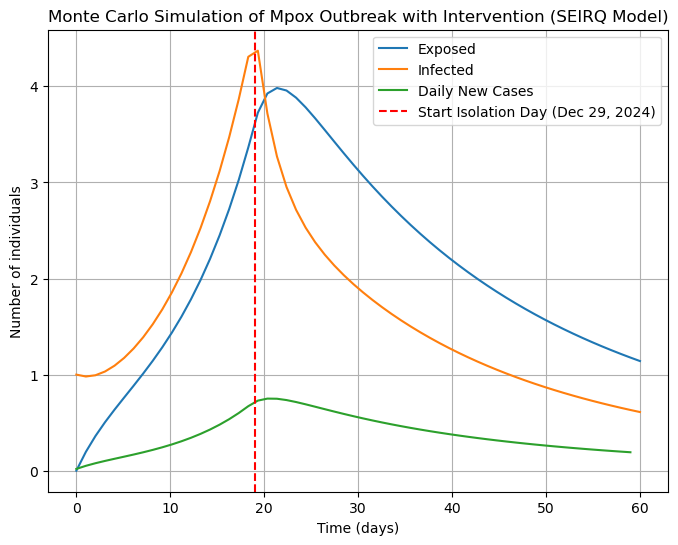

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm

# 模型参数设置
N = 1400000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.46, 2.67)
time_steps = 60  # 模拟时间步长（天）
# 初始恢复速率，后续会根据右偏态传染期更新
initial_recovery_rate = 1 / 9.4
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 0.3  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 开始隔离时间（12月29日为第19天）
start_isolation_day = 19

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 蒙特卡洛模拟
num_simulations = 100  # 模拟次数
S_simulations = []
E_simulations = []
I_simulations = []
R_simulations = []
X_simulations = []
Q_simulations = []

for _ in range(num_simulations):
    # 随机选择 R0 值
    r0 = np.random.uniform(*R0_range)
    # 计算传播能力系数 beta
    beta = r0 * initial_recovery_rate
    # 随机生成潜伏速率 omega
    latency = int(np.random.normal(latency_mean, latency_std))
    latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
    omega = 1 / latency

    # 生成右偏态的传染期
    skew_coefficient = 2  # 偏态系数，正值表示右偏
    infectious_period = skewnorm.rvs(skew_coefficient, loc=infectious_mean, scale=infectious_std)
    # 限制传染期在 5 - 27 天内
    infectious_period = max(5, min(27, infectious_period))
    # 根据传染期更新恢复速率
    recovery_rate = 1 / infectious_period

    # 初始条件
    y0 = [S0, E0, I0, R0, 0, Q0]

    # 求解微分方程
    solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

    S = solution[:, 0]
    E = solution[:, 1]
    I = solution[:, 2]
    R = solution[:, 3]
    X = solution[:, 4]
    Q = solution[:, 5]

    S_simulations.append(S)
    E_simulations.append(E)
    I_simulations.append(I)
    R_simulations.append(R)
    X_simulations.append(X)
    Q_simulations.append(Q)

# 计算平均值
S_mean = np.mean(S_simulations, axis=0)
E_mean = np.mean(E_simulations, axis=0)
I_mean = np.mean(I_simulations, axis=0)
R_mean = np.mean(R_simulations, axis=0)
X_mean = np.mean(X_simulations, axis=0)
Q_mean = np.mean(Q_simulations, axis=0)

# 对 X_mean 进行差分，得到每日新增病例数
daily_new_cases = np.diff(X_mean)
# 由于差分后数据长度减少 1，对应的时间点也需要减少 1
t_daily = t[:-1]

# 可视化结果
plt.figure(figsize=(8, 6))
# plt.plot(t, S_mean, label='Susceptible')
plt.plot(t, E_mean, label='Exposed')
plt.plot(t, I_mean, label='Infected')
# plt.plot(t, R_mean, label='Recovered')
plt.plot(t_daily, daily_new_cases, label='Daily New Cases')
# plt.plot(t, Q_mean, label='Quarantined (Q)')
plt.axvline(x=start_isolation_day, color='r', linestyle='--', label='Start Isolation Day (Dec 29, 2024)')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('Monte Carlo Simulation of Mpox Outbreak with Intervention (SEIRQ Model)')
plt.legend()
plt.grid(True)
plt.show()

2024年12月29日 3 3
2025年01月03日 5 4
2025年01月08日 7 5
2025年01月13日 11 8


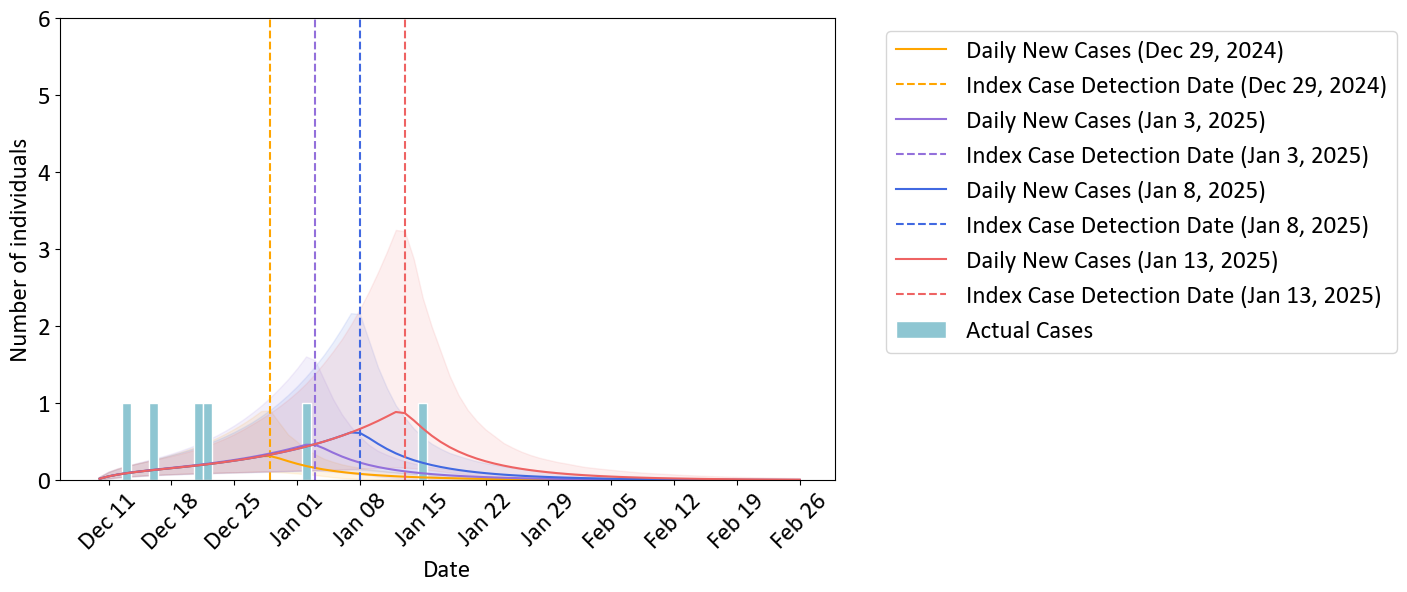

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.46, 2.67)
time_steps = 80  # 模拟时间步长（天）
recovery_rate = 1 / 9.4  # 恢复速率 gamma
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 1  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [19, 24, 29, 34]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(255/255, 165/255, 0/255),(147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255),(238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025', 'Jan 13, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 6))

# 固定偏态参数 a = 1
a = 5
# 定义起始日期
start_date = np.datetime64('2024-12-10')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # 随机选择 R0 值
        r0 = np.random.uniform(*R0_range)
        # 计算传播能力系数 beta
        beta = r0 * recovery_rate
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(5, min(27, infectious_period))  # 限制在 5 - 27 天内

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # 对 X 进行差分，得到每日新增病例数
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # 计算累计病例数
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # 计算平均累计病例数
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # 找到隔离日期对应的索引
    isolation_index = int(start_isolation_day)

    # 计算隔离前和隔离后的累计病例数
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # 将日期转换为指定格式
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y年%m月%d日')

    # 输出结果
    print(f"{formatted_date} {cumulative_before_isolation:.0f} {cumulative_after_isolation:.0f}")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # 计算每日新增病例数的平均值
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
    date_sequence_daily = date_sequence[:-1]

    # 绘制日新增病例数平均值（实线）
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date ({labels[i]})')

# 新增柱状图数据
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# 将日期转换为 numpy 日期格式
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制柱状图
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 6)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

2024年12月29日 隔离前累计病例数: 3 (95% CI: 1 - 7) 隔离后累计病例数: 3 (95% CI: 1 - 6)
2025年01月03日 隔离前累计病例数: 5 (95% CI: 2 - 13) 隔离后累计病例数: 4 (95% CI: 1 - 10)
2025年01月08日 隔离前累计病例数: 7 (95% CI: 3 - 21) 隔离后累计病例数: 6 (95% CI: 2 - 15)
2025年01月13日 隔离前累计病例数: 11 (95% CI: 3 - 36) 隔离后累计病例数: 8 (95% CI: 2 - 24)


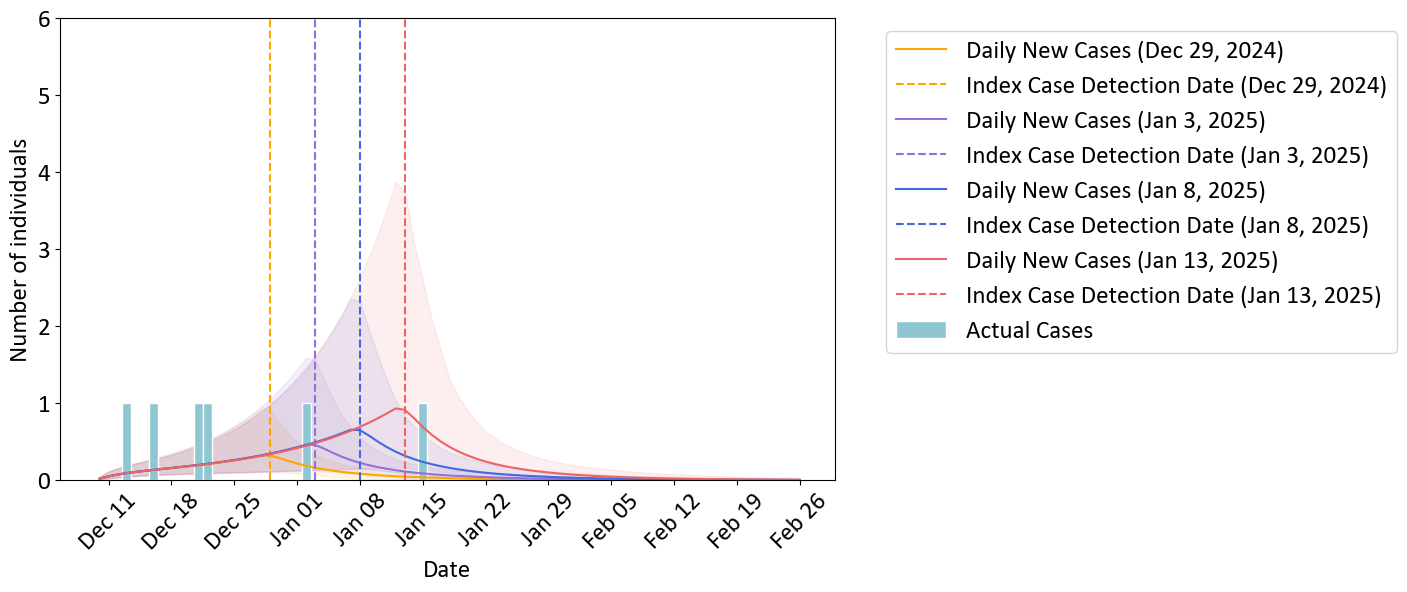

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.46, 2.67)
time_steps = 80  # 模拟时间步长（天）
recovery_rate = 1 / 9.4  # 恢复速率 gamma
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 1  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [19, 24, 29, 34]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(255/255, 165/255, 0/255),(147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255),(238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025', 'Jan 13, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 6))

# 固定偏态参数 a = 1
a = 5
# 定义起始日期
start_date = np.datetime64('2024-12-10')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # 随机选择 R0 值
        r0 = np.random.uniform(*R0_range)
        # 计算传播能力系数 beta
        beta = r0 * recovery_rate
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(5, min(27, infectious_period))  # 限制在 5 - 27 天内

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # 对 X 进行差分，得到每日新增病例数
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # 计算累计病例数
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # 计算平均累计病例数
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # 找到隔离日期对应的索引
    isolation_index = int(start_isolation_day)

    # 计算隔离前和隔离后的累计病例数
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # 计算隔离前和隔离后的累计病例数的 95% 置信区间
    before_isolation_cumulative = all_cumulative_cases[:, isolation_index - 1]
    after_isolation_cumulative = all_cumulative_cases[:, -1] - before_isolation_cumulative

    before_lower = np.percentile(before_isolation_cumulative, 2.5)
    before_upper = np.percentile(before_isolation_cumulative, 97.5)
    after_lower = np.percentile(after_isolation_cumulative, 2.5)
    after_upper = np.percentile(after_isolation_cumulative, 97.5)

    # 将日期转换为指定格式
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y年%m月%d日')

    # 输出结果，包含 95% 置信区间
    print(f"{formatted_date} 隔离前累计病例数: {cumulative_before_isolation:.0f} (95% CI: {before_lower:.0f} - {before_upper:.0f}) 隔离后累计病例数: {cumulative_after_isolation:.0f} (95% CI: {after_lower:.0f} - {after_upper:.0f})")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # 计算每日新增病例数的平均值
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
    date_sequence_daily = date_sequence[:-1]

    # 绘制日新增病例数平均值（实线）
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date ({labels[i]})')

# 新增柱状图数据
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# 将日期转换为 numpy 日期格式
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制柱状图
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 6)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

In [94]:
pip install pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2024年12月29日 隔离前累计病例数: 3 (95% CI: 1 - 8) 隔离后累计病例数: 3 (95% CI: 1 - 6)
2025年01月03日 隔离前累计病例数: 5 (95% CI: 2 - 11) 隔离后累计病例数: 4 (95% CI: 1 - 9)
2025年01月08日 隔离前累计病例数: 7 (95% CI: 3 - 24) 隔离后累计病例数: 6 (95% CI: 2 - 16)
2025年01月13日 隔离前累计病例数: 10 (95% CI: 3 - 32) 隔离后累计病例数: 7 (95% CI: 2 - 22)


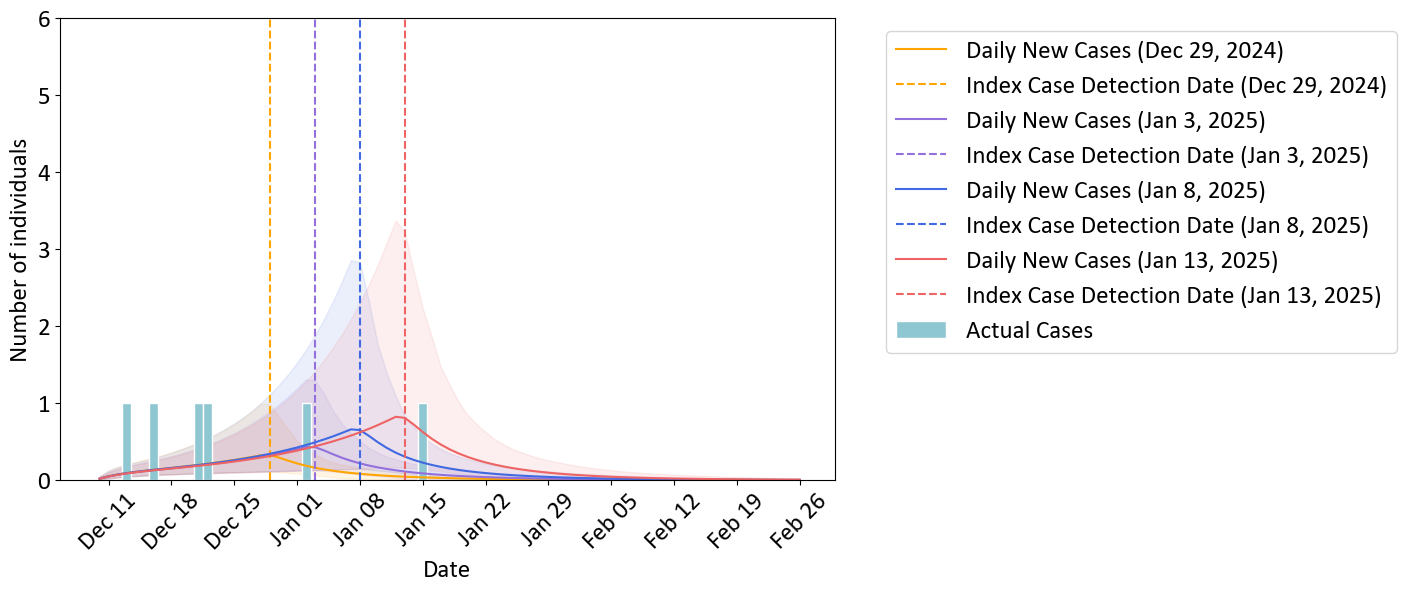

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.46, 2.67)
time_steps = 80  # 模拟时间步长（天）
recovery_rate = 1 / 9.4  # 恢复速率 gamma
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 1  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [19, 24, 29, 34]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(255/255, 165/255, 0/255),(147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255),(238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025', 'Jan 13, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 6))

# 固定偏态参数 a = 1
a = 5
# 定义起始日期
start_date = np.datetime64('2024-12-10')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

# 创建一个 Excel 写入对象
excel_path = r"C:\Users\86187\Desktop\猴痘\绘图\simulation_results2.xlsx"
writer = pd.ExcelWriter(excel_path, engine='openpyxl')

for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # 随机选择 R0 值
        r0 = np.random.uniform(*R0_range)
        # 计算传播能力系数 beta
        beta = r0 * recovery_rate
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(5, min(27, infectious_period))  # 限制在 5 - 27 天内

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # 对 X 进行差分，得到每日新增病例数
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # 计算累计病例数
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # 计算平均累计病例数
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # 找到隔离日期对应的索引
    isolation_index = int(start_isolation_day)

    # 计算隔离前和隔离后的累计病例数
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # 计算隔离前和隔离后的累计病例数的 95% 置信区间
    before_isolation_cumulative = all_cumulative_cases[:, isolation_index - 1]
    after_isolation_cumulative = all_cumulative_cases[:, -1] - before_isolation_cumulative

    before_lower = np.percentile(before_isolation_cumulative, 2.5)
    before_upper = np.percentile(before_isolation_cumulative, 97.5)
    after_lower = np.percentile(after_isolation_cumulative, 2.5)
    after_upper = np.percentile(after_isolation_cumulative, 97.5)

    # 将日期转换为指定格式
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y年%m月%d日')

    # 输出结果，包含 95% 置信区间
    print(f"{formatted_date} 隔离前累计病例数: {cumulative_before_isolation:.0f} (95% CI: {before_lower:.0f} - {before_upper:.0f}) 隔离后累计病例数: {cumulative_after_isolation:.0f} (95% CI: {after_lower:.0f} - {after_upper:.0f})")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # 计算每日新增病例数的平均值
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
    date_sequence_daily = date_sequence[:-1]

    # 绘制日新增病例数平均值（实线）
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date ({labels[i]})')

    # 准备要保存到 Excel 的数据
    data = {
        '次数': np.arange(1, num_simulations + 1),
        '隔离前累计病例数': before_isolation_cumulative,
        '隔离后累计病例数': after_isolation_cumulative
    }
    df = pd.DataFrame(data)

    # 将数据保存到 Excel 的对应工作表
    df.to_excel(writer, sheet_name=labels[i], index=False)

# 新增柱状图数据
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# 将日期转换为 numpy 日期格式
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制柱状图
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 6)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

# 保存 Excel 文件
writer.close()

2024年12月29日 隔离前累计病例数: 3 (95% CI: 2 - 7) 隔离后累计病例数: 3 (95% CI: 2 - 6)
2025年01月03日 隔离前累计病例数: 5 (95% CI: 2 - 11) 隔离后累计病例数: 4 (95% CI: 2 - 9)
2025年01月08日 隔离前累计病例数: 7 (95% CI: 3 - 19) 隔离后累计病例数: 6 (95% CI: 2 - 13)
2025年01月13日 隔离前累计病例数: 10 (95% CI: 4 - 27) 隔离后累计病例数: 8 (95% CI: 3 - 18)


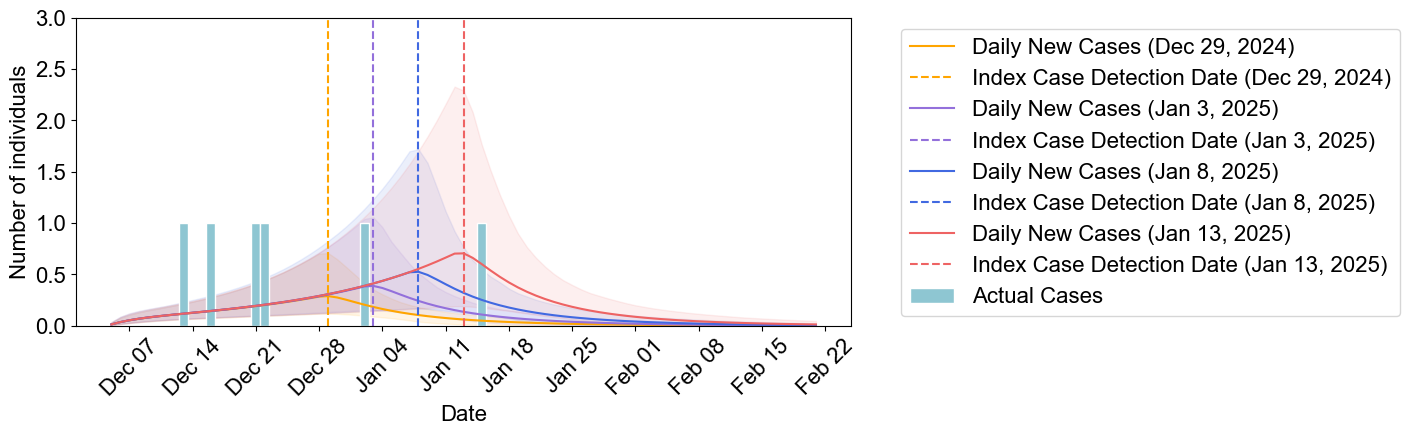

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.78, 2.69)
time_steps = 80  # 模拟时间步长（天）
# 去掉固定的恢复速率定义
# recovery_rate = 1 / 9.4  
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 0.5  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 14
# 根据 95% 置信区间计算标准差
infectious_std = (15 - 13) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [24, 29, 34, 39]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(255/255, 165/255, 0/255), (147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255), (238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025', 'Jan 13, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 4))

# 固定偏态参数 a = 1
a = 0
# 定义起始日期
start_date = np.datetime64('2024-12-05')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

# 创建一个 Excel 写入对象
excel_path = r"C:\Users\86187\Desktop\猴痘\绘图\simulation_results2.xlsx"
writer = pd.ExcelWriter(excel_path, engine='openpyxl')

for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # 随机选择 R0 值
        r0 = np.random.uniform(*R0_range)
        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(4, min(27, infectious_period))  # 限制在 4 - 27 天内
        # 计算恢复速率 gamma
        gamma = 1 / infectious_period
        # 计算传播能力系数 beta
        beta = r0 * gamma
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # 对 X 进行差分，得到每日新增病例数
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # 计算累计病例数
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # 计算平均累计病例数
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # 找到隔离日期对应的索引
    isolation_index = int(start_isolation_day)

    # 计算隔离前和隔离后的累计病例数
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # 计算隔离前和隔离后的累计病例数的 95% 置信区间
    before_isolation_cumulative = all_cumulative_cases[:, isolation_index - 1]
    after_isolation_cumulative = all_cumulative_cases[:, -1] - before_isolation_cumulative

    before_lower = np.percentile(before_isolation_cumulative, 2.5)
    before_upper = np.percentile(before_isolation_cumulative, 97.5)
    after_lower = np.percentile(after_isolation_cumulative, 2.5)
    after_upper = np.percentile(after_isolation_cumulative, 97.5)

    # 将日期转换为指定格式
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y年%m月%d日')

    # 输出结果，包含 95% 置信区间
    print(f"{formatted_date} 隔离前累计病例数: {cumulative_before_isolation:.0f} (95% CI: {before_lower:.0f} - {before_upper:.0f}) 隔离后累计病例数: {cumulative_after_isolation:.0f} (95% CI: {after_lower:.0f} - {after_upper:.0f})")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # 计算每日新增病例数的平均值
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
    date_sequence_daily = date_sequence[:-1]

    # 绘制日新增病例数平均值（实线）
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date ({labels[i]})')

    # 准备要保存到 Excel 的数据
    data = {
        '次数': np.arange(1, num_simulations + 1),
        '隔离前累计病例数': before_isolation_cumulative,
        '隔离后累计病例数': after_isolation_cumulative
    }
    df = pd.DataFrame(data)

    # 将数据保存到 Excel 的对应工作表
    df.to_excel(writer, sheet_name=labels[i], index=False)

# 新增柱状图数据
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# 将日期转换为 numpy 日期格式
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制柱状图
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
# plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 3)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

# 保存 Excel 文件
writer.close()

2024年12月29日 隔离前累计病例数: 3 (95% CI: 2 - 7) 隔离后累计病例数: 3 (95% CI: 2 - 6) 隔离速率: 0.50
2024年12月29日 隔离前累计病例数: 3 (95% CI: 2 - 7) 隔离后累计病例数: 6 (95% CI: 3 - 12) 隔离速率: 0.25
2024年12月29日 隔离前累计病例数: 3 (95% CI: 2 - 7) 隔离后累计病例数: 9 (95% CI: 4 - 22) 隔离速率: 0.17
2024年12月29日 隔离前累计病例数: 3 (95% CI: 2 - 7) 隔离后累计病例数: 14 (95% CI: 5 - 39) 隔离速率: 0.12


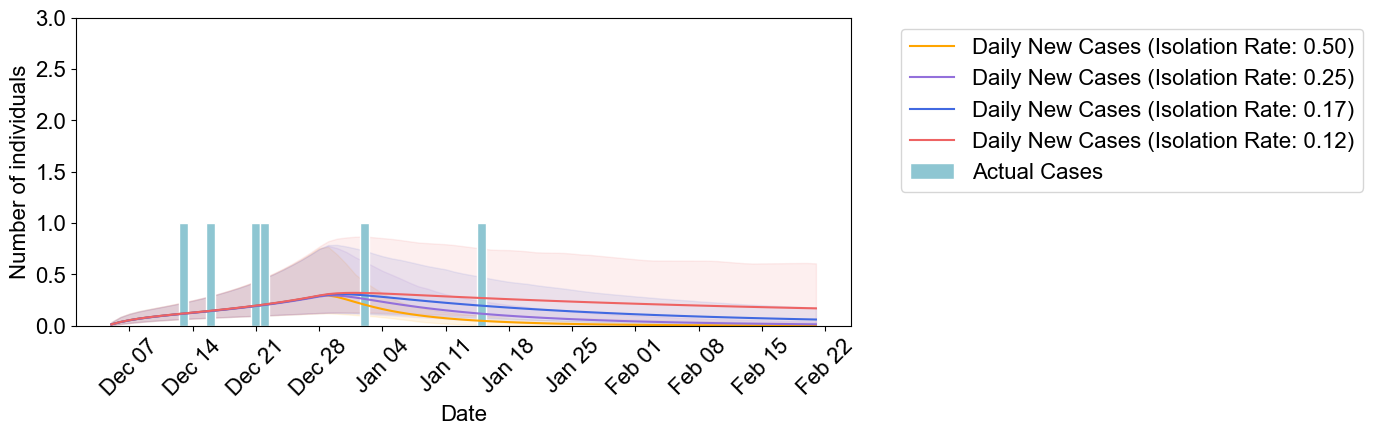

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.78, 2.69)
time_steps = 80  # 模拟时间步长（天）
# 去掉固定的恢复速率定义
# recovery_rate = 1 / 9.4  
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
# 增加不同的隔离速率
enhanced_isolation_rates = [0.5, 1/4, 1/6, 1/8]

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 14
# 根据 95% 置信区间计算标准差
infectious_std = (15 - 13) / 4 

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间，只保留 19
discovery_days = [24]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(255/255, 165/255, 0/255), (147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255)]
labels = [f'Isolation Rate: {rate:.2f}' for rate in enhanced_isolation_rates]

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 4))

# 固定偏态参数 a = 1
a = 0
# 定义起始日期
start_date = np.datetime64('2024-12-05')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

# 创建一个 Excel 写入对象
excel_path = r"C:\Users\86187\Desktop\猴痘\绘图\simulation_results2.xlsx"
writer = pd.ExcelWriter(excel_path, engine='openpyxl')

# 只使用发现病例时间为 19 的情况
start_isolation_day = discovery_days[0]
for i, enhanced_isolation_rate in enumerate(enhanced_isolation_rates):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_daily_new_cases = []
    all_cumulative_cases = []

    for _ in range(num_simulations):
        # 随机选择 R0 值
        r0 = np.random.uniform(*R0_range)
        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(4, min(27, infectious_period))  # 限制在 4 - 27 天内
        # 计算恢复速率 gamma
        gamma = 1 / infectious_period
        # 计算传播能力系数 beta
        beta = r0 * gamma
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        X = solution[:, 4]
        # 对 X 进行差分，得到每日新增病例数
        daily_new_cases = np.diff(X)
        all_daily_new_cases.append(daily_new_cases)

        # 计算累计病例数
        cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
        all_cumulative_cases.append(cumulative_cases)

    all_cumulative_cases = np.array(all_cumulative_cases)

    # 计算平均累计病例数
    average_cumulative_cases = np.mean(all_cumulative_cases, axis=0)

    # 找到隔离日期对应的索引
    isolation_index = int(start_isolation_day)

    # 计算隔离前和隔离后的累计病例数
    cumulative_before_isolation = average_cumulative_cases[isolation_index - 1]
    cumulative_after_isolation = average_cumulative_cases[-1] - cumulative_before_isolation

    # 计算隔离前和隔离后的累计病例数的 95% 置信区间
    before_isolation_cumulative = all_cumulative_cases[:, isolation_index - 1]
    after_isolation_cumulative = all_cumulative_cases[:, -1] - before_isolation_cumulative

    before_lower = np.percentile(before_isolation_cumulative, 2.5)
    before_upper = np.percentile(before_isolation_cumulative, 97.5)
    after_lower = np.percentile(after_isolation_cumulative, 2.5)
    after_upper = np.percentile(after_isolation_cumulative, 97.5)

    # 将日期转换为指定格式
    isolation_date = (start_date + np.timedelta64(int(start_isolation_day), 'D')).astype(datetime)
    formatted_date = isolation_date.strftime('%Y年%m月%d日')

    # 输出结果，包含 95% 置信区间
    print(f"{formatted_date} 隔离前累计病例数: {cumulative_before_isolation:.0f} (95% CI: {before_lower:.0f} - {before_upper:.0f}) 隔离后累计病例数: {cumulative_after_isolation:.0f} (95% CI: {after_lower:.0f} - {after_upper:.0f}) 隔离速率: {enhanced_isolation_rate:.2f}")

    all_daily_new_cases = np.array(all_daily_new_cases)

    # 计算每日新增病例数的平均值
    daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

    # 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
    date_sequence_daily = date_sequence[:-1]

    # 绘制日新增病例数平均值（实线）
    plt.plot(date_sequence_daily, daily_new_cases_mean, color=new_colors[i],
             label=f'Daily New Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    #isolation_date = start_date + np.timedelta64(int(start_isolation_day), 'D')
    #plt.axvline(x=isolation_date, color=new_colors[i], linestyle='--', label=f'Index Case Detection Date (Isolation Rate: {enhanced_isolation_rate:.2f})')

    # 准备要保存到 Excel 的数据
    data = {
        '次数': np.arange(1, num_simulations + 1),
        '隔离前累计病例数': before_isolation_cumulative,
        '隔离后累计病例数': after_isolation_cumulative
    }
    df = pd.DataFrame(data)

    # 将数据保存到 Excel 的对应工作表
    df.to_excel(writer, sheet_name=f'IsolationRate_{enhanced_isolation_rate:.2f}', index=False)

# 新增柱状图数据
dates = ['2024.12.10', '2024.12.13', '2024.12.16', '2024.12.21', '2024.12.22', '2025.1.2', '2025.1.15']
values = [0, 1, 1, 1, 1, 1, 1]

# 将日期转换为 numpy 日期格式
date_objects = np.array([np.datetime64(datetime.strptime(date, '%Y.%m.%d').strftime('%Y-%m-%d')) for date in dates])

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制柱状图
plt.bar(date_objects, values, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cases')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
# plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Isolation Rates')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 3)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

# 保存 Excel 文件
writer.close()

最后一天累计病例数：153（95% CI: 20 - 817）


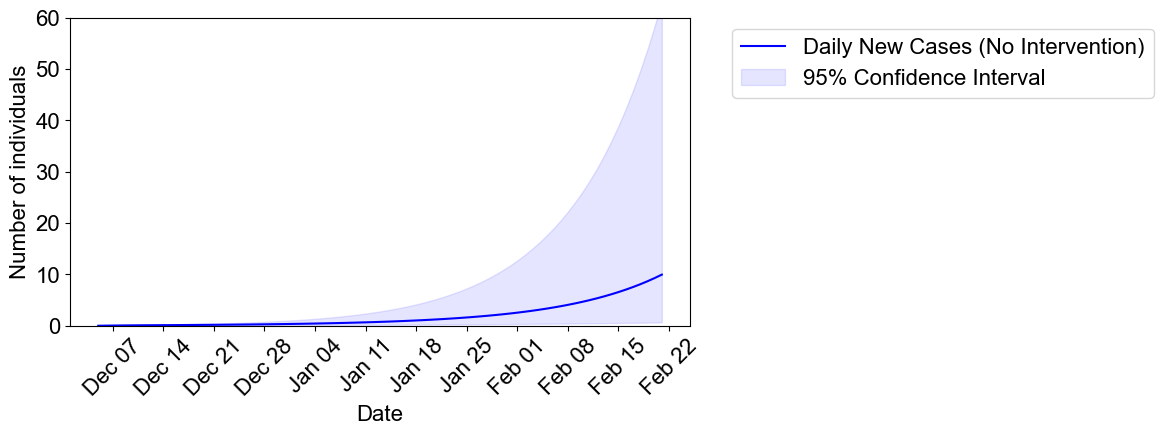

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import matplotlib.dates as mdates

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

# 模型参数设置
N = 300000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
# 使用代码一的 R0 范围
R0_range = (1.78, 2.69)
time_steps = 80  # 模拟时间步长（天）
# 去掉固定的恢复速率定义，后续根据 infectious_period 计算
# recovery_rate = 1 / 9.4
# 无干预情况下，隔离速率始终为 0
isolation_rate = 0
enhanced_isolation_rate = 0

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
# 使用代码一的传染期均值
infectious_mean = 14
# 使用代码一根据 95% 置信区间计算的标准差
infectious_std = (15 - 13) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 定义起始日期
start_date = np.datetime64('2024-12-05')
# 生成对应的日期序列
date_sequence = np.array([start_date + np.timedelta64(int(i), 'D') for i in t])

# 蒙特卡洛模拟
num_simulations = 1000  # 模拟次数
all_daily_new_cases = []
all_cumulative_cases = []

# 固定偏态参数，使用代码一的值
a = 0

for _ in range(num_simulations):
    # 随机选择 R0 值
    r0 = np.random.uniform(*R0_range)
    # 生成右偏态的传染期
    infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
    # 使用代码一的取值范围
    infectious_period = max(4, min(27, infectious_period))
    # 计算恢复速率 gamma
    gamma = 1 / infectious_period
    # 计算传播能力系数 beta
    beta = r0 * gamma
    # 随机生成潜伏速率 omega
    latency = int(np.random.normal(latency_mean, latency_std))
    latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
    omega = 1 / latency

    # 初始条件
    y0 = [S0, E0, I0, R0, 0, Q0]

    # 求解微分方程，由于无干预，隔离相关参数都为 0
    solution = odeint(seirq_model, y0, t, args=(beta, omega, gamma, isolation_rate, enhanced_isolation_rate, 0))

    X = solution[:, 4]
    # 对 X 进行差分，得到每日新增病例数
    daily_new_cases = np.diff(X)
    all_daily_new_cases.append(daily_new_cases)

    # 计算累计病例数（补 0 后累加）
    cumulative_cases = np.cumsum(np.insert(daily_new_cases, 0, 0))
    all_cumulative_cases.append(cumulative_cases)

all_cumulative_cases = np.array(all_cumulative_cases)

# 计算最后一天的累计病例数
final_cumulative_mean = np.mean(all_cumulative_cases[:, -1])
final_cumulative_lower = np.percentile(all_cumulative_cases[:, -1], 2.5)
final_cumulative_upper = np.percentile(all_cumulative_cases[:, -1], 97.5)

print(f"最后一天累计病例数：{final_cumulative_mean:.0f}（95% CI: {final_cumulative_lower:.0f} - {final_cumulative_upper:.0f}）")

all_daily_new_cases = np.array(all_daily_new_cases)

# 计算每日新增病例数的平均值
daily_new_cases_mean = np.mean(all_daily_new_cases, axis=0)
# 计算 95% 置信区间
lower_bound = np.percentile(all_daily_new_cases, 2.5, axis=0)
upper_bound = np.percentile(all_daily_new_cases, 97.5, axis=0)

# 由于差分后数据长度减少 1，对应的日期序列也需要减少 1
date_sequence_daily = date_sequence[:-1]

# 可视化结果
plt.figure(figsize=(8, 4))

# 绘制日新增病例数平均值（实线）
plt.plot(date_sequence_daily, daily_new_cases_mean, color='blue', label='Daily New Cases (No Intervention)')
# 绘制 95% 置信区间
plt.fill_between(date_sequence_daily, lower_bound, upper_bound, color='blue', alpha=0.1, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak without Intervention')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 60)

# 设置日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # 每 7 天显示一个日期

# 设置横坐标日期倾斜 45°
ax.tick_params(axis='x', rotation=45)

plt.show()

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    # 无干预情况下，始终使用 0 隔离速率
    current_isolation_rate = 0

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

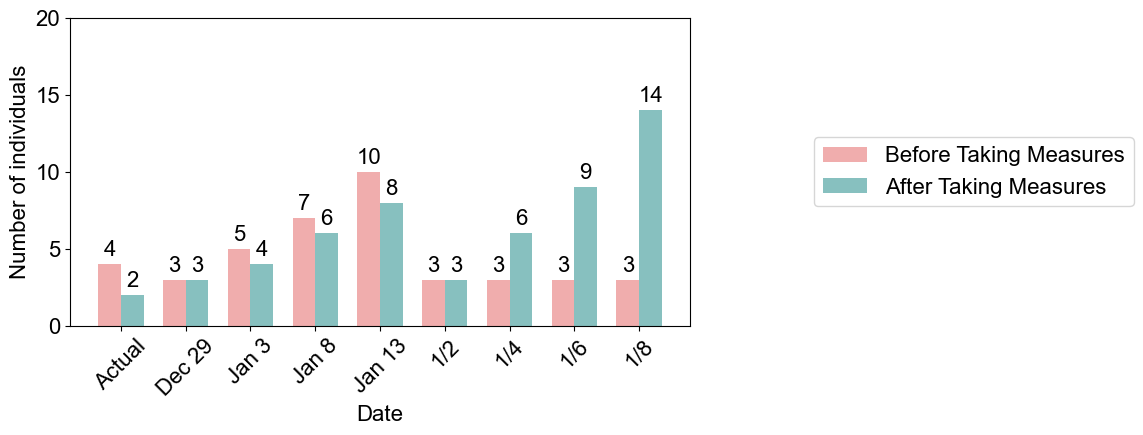

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取Excel数据
file_path = r"C:\Users\86187\Desktop\猴痘\绘图\累计病例数柱状图\累计病例数柱状图.xlsx"
df = pd.read_excel(file_path, sheet_name='group1')

# 提取数据，使用索引选取列
labels = df.iloc[:, 0]  # 第一列
before_measures = df.iloc[:, 1]  # 第二列
after_measures = df.iloc[:, 2]  # 第三列

# 设置全局字体为 Calibri，大小为 18
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

# 设置图形大小
plt.figure(figsize=(8, 4))

# 绘制柱状图
bar_width = 0.35
bar_positions1 = np.arange(len(labels))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

bars1 = plt.bar(bar_positions1, before_measures, width=bar_width, color=(240/255, 173/255, 173/255), label='Before Taking Measures')
bars2 = plt.bar(bar_positions2, after_measures, width=bar_width, color=(135/255, 192/255, 191/255), label='After Taking Measures')

# 在柱子上方标记数值
for bar in bars1:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# 设置横轴标签和标题
plt.xlabel('Date')
plt.ylabel('Number of individuals')

# 设置横轴刻度标签
plt.xticks([pos + bar_width / 2 for pos in bar_positions1], labels, rotation=45)

# 设置纵轴范围，最高值为 16
plt.ylim(0, 20)

# 添加图例，并将其放置在图片外面右侧
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center left', borderaxespad=0.)

# 显示图形
plt.show()

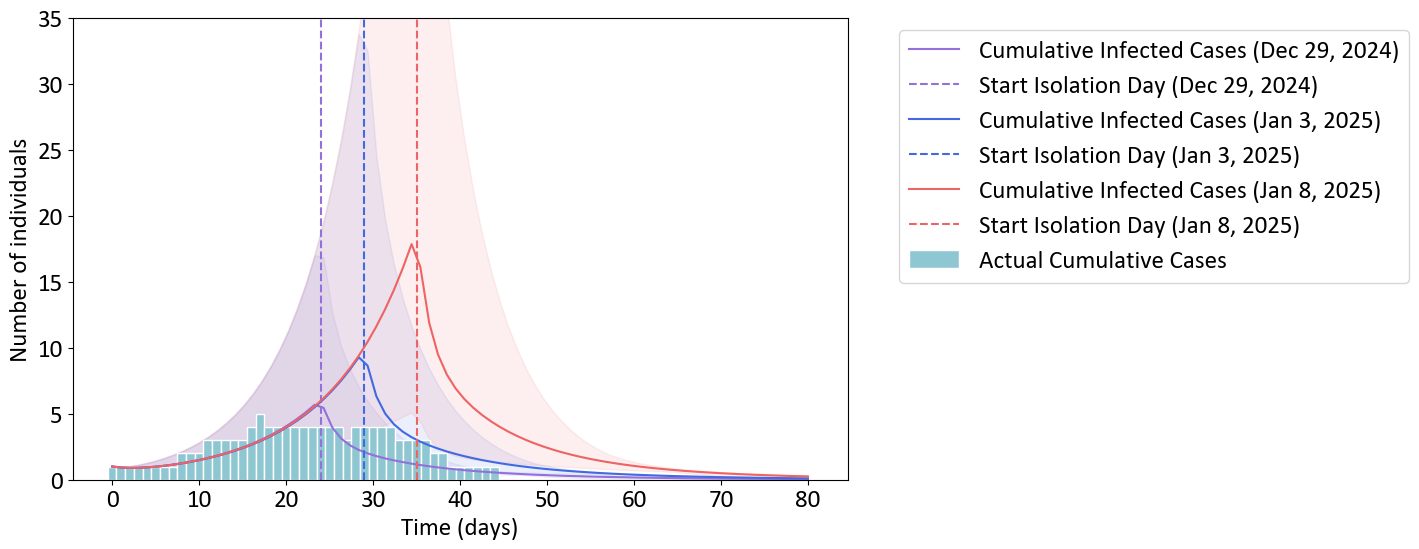

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import pandas as pd

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# 模型参数设置
N = 1400000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
# 直接设置 R0 为 2.89
r0 = 2.89
time_steps = 80  # 模拟时间步长（天）
recovery_rate = 1 / 9.4  # 恢复速率 gamma
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 0.5  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [24, 29, 35]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 6))

# 固定偏态参数 a = 3
a = 5
for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_infected_cases = []

    for _ in range(num_simulations):
        # 直接使用固定的 R0 值计算传播能力系数 beta
        beta = r0 * recovery_rate
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(5, min(27, infectious_period))  # 限制在 5 - 27 天内

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        # 提取模拟的累计感染病例数 I
        I = solution[:, 2]
        all_infected_cases.append(I)

    all_infected_cases = np.array(all_infected_cases)

    # 计算累计感染病例数的平均值
    infected_cases_mean = np.mean(all_infected_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_infected_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_infected_cases, 97.5, axis=0)

    # 绘制模拟的累计感染病例数平均值（实线）
    plt.plot(t, infected_cases_mean, color=new_colors[i],
             label=f'Cumulative Infected Cases ({labels[i]})')
    # 绘制 95% 置信区间
    plt.fill_between(t, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    plt.axvline(x=start_isolation_day, color=new_colors[i], linestyle='--', label=f'Start Isolation Day ({labels[i]})')

# 读取文件
try:
    # 指定编码格式为 gbk
    data = pd.read_csv('./累计病例.csv', encoding='gbk')
    steps = data.iloc[:, 1].values
    cumulative_cases = data.iloc[:, 4].values
except FileNotFoundError:
    print("文件 './累计病例.csv' 未找到，请检查文件路径和文件名。")
except UnicodeDecodeError:
    print("无法使用指定的编码格式读取文件，请尝试其他编码格式。")
    exit()

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制实际的累计病例数柱状图
plt.bar(steps, cumulative_cases, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cumulative Cases')

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 35)

plt.show()

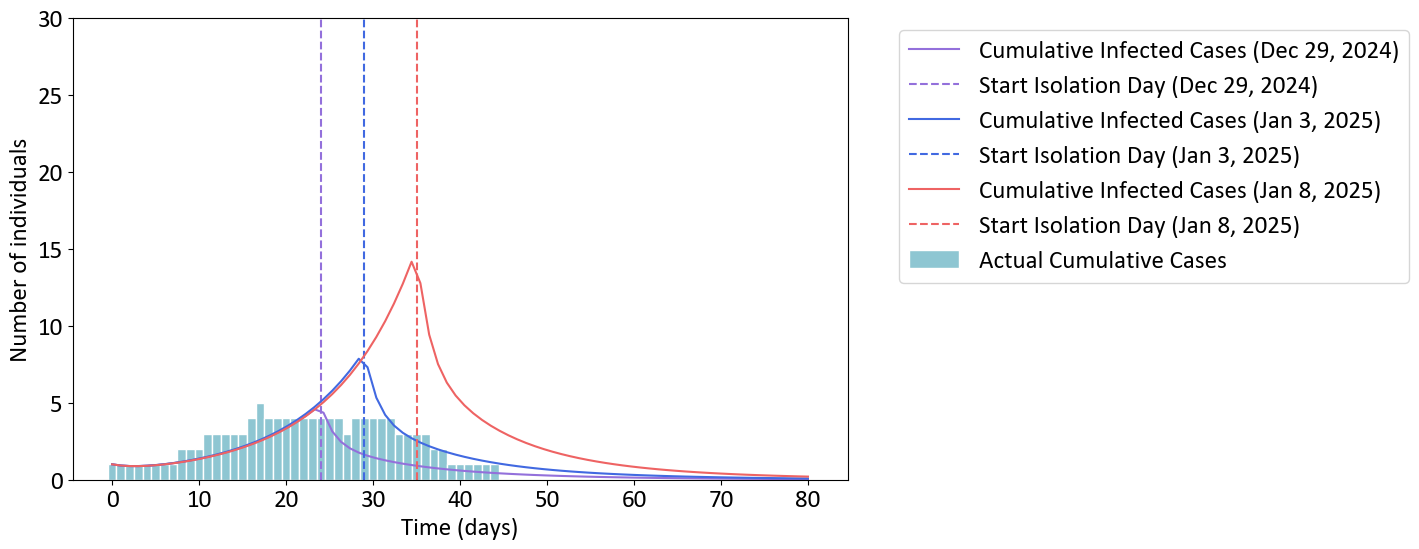

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import skewnorm
from datetime import datetime
import pandas as pd

# 设置全局字体为 Calibri，大小为 18 号
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['font.size'] = 18

# 模型参数设置
N = 1400000000  # 模拟人口数
I0 = 1  # 初始感染人数
S0 = N - I0
E0 = 0
R0 = 0
Q0 = 0  # 初始隔离人数
R0_range = (1.44, 3.33)
time_steps = 80  # 模拟时间步长（天）
recovery_rate = 1 / 9.4  # 恢复速率 gamma
isolation_rate = 0  # 假设的隔离速率，可根据实际情况调整
enhanced_isolation_rate = 0.5  # 发现病例后加大的隔离速率

# 潜伏期和传染期的参数
latency_mean = 7
latency_std = (12 - 2) / 4  # 假设正态分布 95% 数据落在 2 - 12 天内
infectious_mean = 25
infectious_std = (27 - 5) / 4

# 时间点
t = np.linspace(0, time_steps, time_steps)

# 不同发现病例的时间
discovery_days = [24, 29, 35]
# 将 RGB 值转换为 0 到 1 之间的小数
new_colors = [(147/255, 112/255, 219/255), (65/255, 105/255, 225/255), (238/255, 99/255, 99/255)]
labels = ['Dec 29, 2024', 'Jan 3, 2025', 'Jan 8, 2025']

# 定义 SEIRQ 模型的微分方程
def seirq_model(y, t, beta, omega, gamma, isolation_rate, enhanced_isolation_rate, start_isolation_day):
    S, E, I, R, X, Q = y
    if t >= start_isolation_day:
        current_isolation_rate = enhanced_isolation_rate
    else:
        current_isolation_rate = isolation_rate

    dSdt = -beta * (S * I) / N
    dEdt = beta * (S * I) / N - omega * E
    dIdt = omega * E - gamma * I - current_isolation_rate * I
    dRdt = gamma * I + gamma * Q  # 康复人数包括未隔离和隔离后康复的
    dXdt = omega * E
    dQdt = current_isolation_rate * I - gamma * Q  # 进入隔离的人数减去隔离后康复的人数
    return [dSdt, dEdt, dIdt, dRdt, dXdt, dQdt]

# 可视化结果
plt.figure(figsize=(10, 6))

# 固定偏态参数 a = 5
a1 = 1
a2 = 3
for i, start_isolation_day in enumerate(discovery_days):
    # 蒙特卡洛模拟
    num_simulations = 1000  # 模拟次数
    all_infected_cases = []

    for _ in range(num_simulations):
        # 生成右偏态的 R0 值
        r0 = skewnorm.rvs(a1, loc=np.mean(R0_range), scale=(R0_range[1] - R0_range[0]) / 4)
        # 确保 R0 值在指定范围内
        r0 = max(R0_range[0], min(R0_range[1], r0))
        # 计算传播能力系数 beta
        beta = r0 * recovery_rate
        # 随机生成潜伏速率 omega
        latency = int(np.random.normal(latency_mean, latency_std))
        latency = max(2, min(12, latency))  # 限制在 2 - 12 天内
        omega = 1 / latency

        # 生成右偏态的传染期
        infectious_period = skewnorm.rvs(a2, loc=infectious_mean, scale=infectious_std)
        infectious_period = max(5, min(27, infectious_period))  # 限制在 5 - 27 天内

        # 初始条件
        y0 = [S0, E0, I0, R0, 0, Q0]

        # 求解微分方程
        solution = odeint(seirq_model, y0, t, args=(beta, omega, recovery_rate, isolation_rate, enhanced_isolation_rate, start_isolation_day))

        # 提取模拟的累计感染病例数 I
        I = solution[:, 2]
        all_infected_cases.append(I)

    all_infected_cases = np.array(all_infected_cases)

    # 计算累计感染病例数的平均值
    infected_cases_mean = np.mean(all_infected_cases, axis=0)
    # 计算 95% 置信区间
    lower_bound = np.percentile(all_infected_cases, 2.5, axis=0)
    upper_bound = np.percentile(all_infected_cases, 97.5, axis=0)

    # 绘制模拟的累计感染病例数平均值（实线）
    plt.plot(t, infected_cases_mean, color=new_colors[i],
             label=f'Cumulative Infected Cases ({labels[i]})')
    # 绘制 95% 置信区间
    #plt.fill_between(t, lower_bound, upper_bound, color=new_colors[i], alpha=0.1)

    # 添加开始隔离日期的垂直线，颜色与对应日期一致
    plt.axvline(x=start_isolation_day, color=new_colors[i], linestyle='--', label=f'Start Isolation Day ({labels[i]})')

# 读取文件
try:
    # 指定编码格式为 gbk
    data = pd.read_csv('./累计病例.csv', encoding='gbk')
    steps = data.iloc[:, 1].values
    cumulative_cases = data.iloc[:, 4].values
except FileNotFoundError:
    print("文件 './累计病例.csv' 未找到，请检查文件路径和文件名。")
except UnicodeDecodeError:
    print("无法使用指定的编码格式读取文件，请尝试其他编码格式。")
    exit()

# 定义柱子颜色和边框颜色
bar_color = (142/255, 198/255, 210/255)
edge_color = (255/255, 255/255, 255/255)

# 绘制实际的累计病例数柱状图
plt.bar(steps, cumulative_cases, color=bar_color, edgecolor=edge_color, width=1, label='Actual Cumulative Cases')

plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
#plt.title('Monte Carlo Simulation of Mpox Outbreak with Different Discovery Days')
# 处理图例重复问题
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# 将图例放在图片右侧
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
# 去除背景网格线
plt.grid(False)

# 设置纵坐标范围
plt.ylim(0, 30)

plt.show()